# 3 Layer CNN with Deep Learnig framework

In [2]:
import os
import datetime
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(10, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(10, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 10)        910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 10)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 10)          910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 10)                0

In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

for i in range(len(model.layers)):
    print(model.layers[i])

In [7]:
"""
#log_dir = "C:/Users/leegu/logs/3-layer_CNN_with_framework/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#log_dir = "C:/Users/MSI/logs/3-layer_CNN-with-framework/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "C:/Users/MSI/logs/3-layer_CNN-with-framework/for_report"

try:
    os.stat(log_dir)
except:
    os.mkdir(log_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=100000000)
model.fit(train_images,
          train_labels,
          epochs=5,
          callbacks=[tensorboard_callback],
          validation_data=(test_images, test_labels))
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
"""

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 105us/sample - loss: 0.5512 - accuracy: 0.8285 - val_loss: 0.2386 - val_accuracy: 0.9276
Epoch 2/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.2171 - accuracy: 0.9340 - val_loss: 0.1684 - val_accuracy: 0.9471
Epoch 3/5
60000/60000 [==============================] - 5s 81us/sample - loss: 0.1736 - accuracy: 0.9473 - val_loss: 0.1470 - val_accuracy: 0.9525
Epoch 4/5
60000/60000 [==============================] - 5s 81us/sample - loss: 0.1492 - accuracy: 0.9546 - val_loss: 0.1346 - val_accuracy: 0.9599
Epoch 5/5
60000/60000 [==============================] - 5s 81us/sample - loss: 0.1347 - accuracy: 0.9593 - val_loss: 0.1126 - val_accuracy: 0.9669
10000/10000 - 0s - loss: 0.1126 - accuracy: 0.9669


In [8]:
#model.save_weights('./checkpoints/3-layer_CNN-with-framework')

In [9]:
model.load_weights('./checkpoints/3-layer_CNN-with-framework')
loss,acc = model.evaluate(test_images,  test_labels, verbose=2)

10000/10000 - 0s - loss: 0.1126 - accuracy: 0.9669


# CAM (Class Activation Map)
reference: https://github.com/jacobgil/keras-cam

In [23]:
def vis_CAM(model, img):
    cnn_model = model
    img = np.float32(img)
    original_img = img
    class_weights = cnn_model.layers[-1].get_weights()[0] 
    
    get_last_conv2D_layer_output = tf.keras.backend.function([cnn_model.layers[0].input],
                                     [cnn_model.layers[4].output])
    conv_outputs = np.array(get_last_conv2D_layer_output([img]))
    conv_outputs = conv_outputs[0][0]
    cam = np.zeros(dtype = np.float32, shape = (3, 3))
    
    for i, w in enumerate(class_weights[1, :]):
        cam += w * conv_outputs[:, :, i]    
        
    cam /= np.max(cam)
    
    cam_resize = cv2.resize(cam, (28, 28))
    
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap_resize = cv2.applyColorMap(np.uint8(255*cam_resize), cv2.COLORMAP_JET)
    
    img = heatmap_resize*0.5 + original_img

    fig = plt.figure()
    
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(original_img[0], cmap="gray")
    ax1.set_title('original')
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(heatmap)
    ax2.set_title('cam')
    ax2.axis("off")

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(img[0])
    ax3.set_title('resize and overlap')
    ax3.axis("off")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


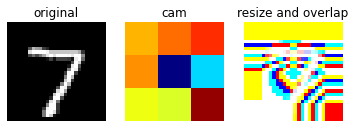

In [24]:
vis_CAM(model, test_images[0:1])

## for Report

In [14]:
import io

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

In [15]:
result = []
for i in range(10):
    result.append([])

predict = model.predict(test_images)
input_list = list(zip(test_images,test_labels))
for i in range(len(test_images)):
    if test_labels[i] == list(predict[i]).index(max(predict[i])):
        result[test_labels[i]].append((i, round(max(predict[i]), 3)*100))

for i in range(len(result)):
    result[i].sort(key=lambda x:x[1])
    

def vis_top3_img_to_tensorboard(result, label):
    best_idx, best_prob = result[label][-1]
    second_idx, second_prob = result[label][-2]
    third_idx, third_prob = result[label][-3]

    log_dir = "C:/Users/MSI/logs/3-layer_CNN-with-framework/for_report/images"
    file_writer = tf.summary.create_file_writer(log_dir)
    
    fig = plt.figure()

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(test_images[best_idx], cmap="gray")
    ax1.set_title(str(best_prob))
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(test_images[second_idx], cmap="gray")
    ax2.set_title(str(second_prob))
    ax2.axis("off")

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(test_images[third_idx], cmap="gray")
    ax3.set_title(str(third_prob))
    ax3.axis("off")
    plt.show()
    
    with file_writer.as_default():
        tf.summary.image("Label:"+str(label) +", Prob List: "+str([best_prob, second_prob, third_prob]), np.array([test_images[best_idx],test_images[second_idx],test_images[third_idx]]).reshape(3,28,28,1), step=0)
        #tf.summary.image("Label:"+str(label) +", Second Prob: "+str(second_prob), .reshape(-1,28,28,1), step=0)
        #tf.summary.image("Label:"+str(label) +", Third Prob: "+str(third_prob), test_images[third_idx].reshape(-1,28,28,1), step=0)

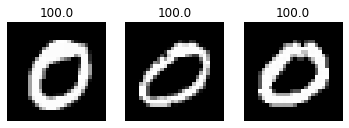

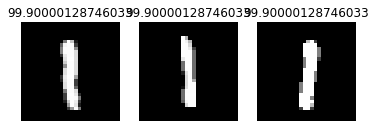

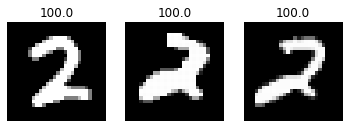

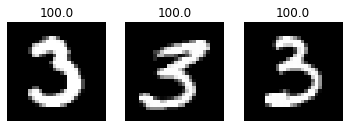

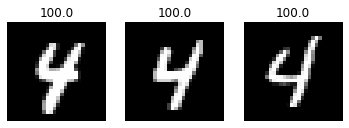

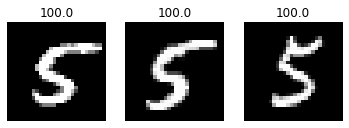

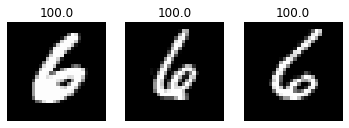

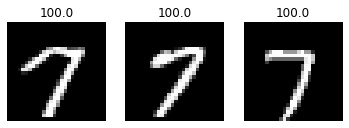

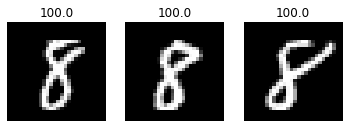

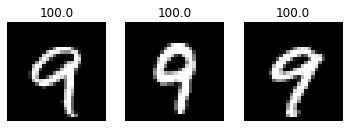

In [16]:
vis_top3_img_to_tensorboard(result, 0)
vis_top3_img_to_tensorboard(result, 1)
vis_top3_img_to_tensorboard(result, 2)
vis_top3_img_to_tensorboard(result, 3)
vis_top3_img_to_tensorboard(result, 4)
vis_top3_img_to_tensorboard(result, 5)
vis_top3_img_to_tensorboard(result, 6)
vis_top3_img_to_tensorboard(result, 7)
vis_top3_img_to_tensorboard(result, 8)
vis_top3_img_to_tensorboard(result, 9)

<AxesSubplot:>

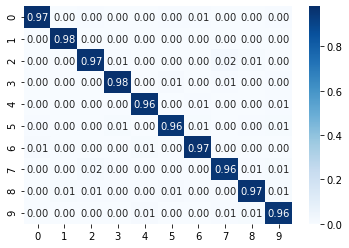

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

prob_list = model.predict(test_images)
pred_list =[]
for i in range(len(test_images)):
    pred_list.append(list(prob_list[i]).index(max(prob_list[i])))


result = confusion_matrix(pred_list, test_labels, normalize="pred")
sn.heatmap(result, annot=True, fmt='.2f', cmap="Blues")